In [1]:
import pandas as pd               
import numpy as np
import math

In [2]:
import spiceypy as sp
import astropy.coordinates
import re
import sgp4.api as sg
import astropy.units as u
from astropy.coordinates import SkyCoord

In [35]:
import matplotlib.pyplot as plt
import os
import sys
from timeit import default_timer as timer
from astropy.time import Time
from astropy.time import TimeDelta
import datetime as dt
import timeit
import skyfield
from skyfield.framelib import ecliptic_frame # For rotation matrices
from skyfield.api import EarthSatellite # For time calculations
from skyfield.api import load, wgs84 # For timescale

#### Let us start with reading in the first 10000 LSST observations for Main Belt Asteroids (S1 in the Synthetic Solar System model)

In [4]:
path = "/data/projects/lsst/baseline_fbs_v1p7p1/"
dir_list = os.listdir(path)

dflist=[]

for d in dir_list:
    if(d[0:2]=='S1'):
        dflist.append(pd.read_hdf('/data/projects/lsst/baseline_fbs_v1p7p1/'+d+'/visit-0000000.h5'))
        dflist.append(pd.read_hdf('/data/projects/lsst/baseline_fbs_v1p7p1/'+d+'/visit-0010000.h5'))

In [5]:
# every dataframe looks like this
dflist[0].columns

Index(['ObjID', 'FieldID', 'FieldMJD', 'AstRange(km)', 'AstRangeRate(km/s)',
       'AstRA(deg)', 'AstRARate(deg/day)', 'AstDec(deg)',
       'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)', 'Ast-Sun(J2000y)(km)',
       'Ast-Sun(J2000z)(km)', 'Ast-Sun(J2000vx)(km/s)',
       'Ast-Sun(J2000vy)(km/s)', 'Ast-Sun(J2000vz)(km/s)',
       'Obs-Sun(J2000x)(km)', 'Obs-Sun(J2000y)(km)', 'Obs-Sun(J2000z)(km)',
       'Obs-Sun(J2000vx)(km/s)', 'Obs-Sun(J2000vy)(km/s)',
       'Obs-Sun(J2000vz)(km/s)', 'Sun-Ast-Obs(deg)', 'V', 'V(H=0)',
       'MaginFilterTrue', 'AstrometricSigma(mas)', 'PhotometricSigma(mag)',
       'SNR', 'AstrometricSigma(deg)', 'MaginFilter', 'dmagDetect',
       'AstRATrue(deg)', 'AstDecTrue(deg)', 'filter'],
      dtype='object')

In [6]:
# concatenate them into a single dataframe
dfin=pd.concat(dflist)

In [7]:
# we can sort the resulting dataframe by by FieldID
dfin.sort_values(['FieldID'], inplace=True)

In [8]:
# then grouping and counting is a little faster. It seems that FieldID 0 has the most observations
dfin.groupby(['FieldID']).count()['ObjID']

FieldID
0        390
1        363
2        164
3         96
4         77
        ... 
19992      3
19993      1
19996      2
19998      3
19999      1
Name: ObjID, Length: 16608, dtype: int64

In [9]:
def icrf2radec(pos, deg=True):
    """Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    pos ... real, dim=[n, 3], 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    if(pos.ndim>1):
        r=norm(pos,axis=1)
        xu=pos[:,0]/r
        yu=pos[:,1]/r
        zu=pos[:,2]/r
    else:
        r=norm(pos)
        xu=pos[0]/r
        yu=pos[1]/r
        zu=pos[2]/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
    
    return ra, dec

In [10]:
def radec2icrf(ra, dec, deg=True):
    """Convert Right Ascension and Declination to ICRF xyz unit vector.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    x,y,z ... 3D vector of unit length (ICRF)
    """
    deg2rad=np.deg2rad
    array=np.array
    cos=np.cos
    sin=np.sin
    
    if(deg):
        a = deg2rad(ra)
        d = deg2rad(dec)
    else:
        a = array(ra)
        d = array(dec)
    
    cosd = cos(d)
    x = cosd*cos(a)
    y = cosd*sin(a)
    z = sin(d)
    
    return array([x, y, z])

In [11]:
field_ids = dfin['FieldID'].unique()

In [12]:
dates = dfin['FieldMJD'].unique()

In [13]:
print("Earliest field date: " + str(min(dates)) + " or 10-01-2022 at 23:39:19.663 UTC")
print("Last field date: " + str(max(dates)) + " or 10-30-2022 at 05:03:20.104 UTC")

Earliest field date: 59853.98564424414 or 10-01-2022 at 23:39:19.663 UTC
Last field date: 59882.21064935192 or 10-30-2022 at 05:03:20.104 UTC


In [14]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/home/davidar6/Solution Testing': ['.ipynb_checkpoints', 'starlink_tle.txt', 'starlink_tle2.txt', 'ActiveSatellites_tle.txt', 'satellites - vector distance - Starlink 2 TLE.ipynb', 'satellites - vector distance - Starlink 1 - Time.ipynb', 'satellites - vector distance - Active Satellites TLE.ipynb', 'last30days_tle.txt', '100brightest_tle.txt', 'satellites - vector distance - 100 Brightest TLE.ipynb', 'satellites - vector distance - Last 30 Days.ipynb', 'satellites - vector distance - Starlink 2 TLE-Fix.ipynb', 'satellites - vector distance - Starlink 1 - Time - Data.ipynb', 'satellites - vector distance - Starlink 1 - Topocentric vector.ipynb', 'satellites - vector distance - Starlink 1 - Topocentric vector - degrees.ipynb', 'satellites - vector distance - Starlink 1 - Naive Topocentric vector .ipynb']


In [15]:
# open the TLE files
with open('/home/davidar6/Solution Testing/starlink_tle.txt') as f:
    starlinks = f.read().splitlines() 

In [16]:
# split up the list into 3-line lists for each satellite
chunks = [starlinks[n:n + 3] for n in range(0, len(starlinks), 3)]

In [17]:
print("There are " + str(len(chunks)) + " satellites")

There are 1653 satellites


In [18]:
import warnings

In [19]:
def crosstrackdistance(lat1, long1, lat2, long2, lat3, long3):
    c1 = SkyCoord(ra=long1*u.radian, dec=lat1*u.radian, frame='icrs')  
    c2 = SkyCoord(ra=long2*u.radian, dec=lat2*u.radian, frame='icrs') 
    c3 = SkyCoord(ra=long3*u.radian, dec=lat3*u.radian, frame='icrs')
    
    c1.representation_type = 'cartesian'
    c2.representation_type = 'cartesian'
    c3.representation_type = 'cartesian'
    
    P1 = c1.x.value, c1.y.value, c1.z.value
    P2 = c2.x.value, c2.y.value, c2.z.value
    P3 = c3.x.value, c3.y.value, c3.z.value
    
    S = np.cross(P1,P2)
    dot = np.dot(S,P3)
    
    dist = np.arctan2(dot/np.linalg.norm(S), np.sqrt(1 - (dot/np.linalg.norm(S))**2 )) 
    
    return dist

In [20]:
# Rubin coordinates
    # latRubin = -30.24506 (Degrees)
    # longRubin = -70.74913 (Degrees)
    # DecRubin = -30.24506 (Radians)
    # RaRubin = 289.251 (Radians)
    # Earth radius = 6371 km

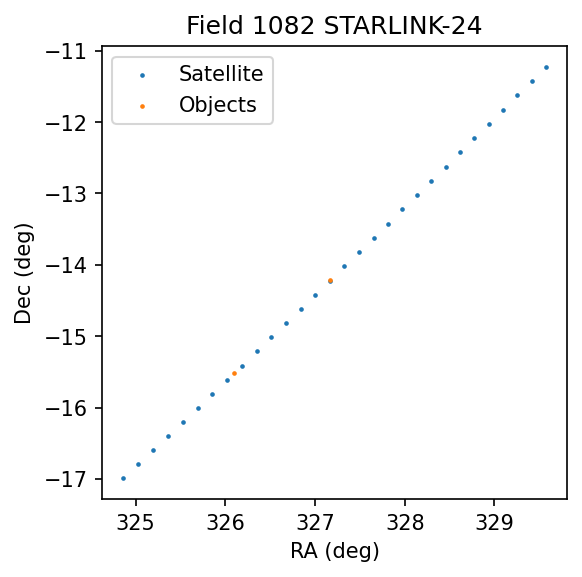

Number of objects affected: 2

Satellite times:
[59855.088124053495, 59855.08814720164, 59855.088170349794, 59855.08819349794, 59855.08821664609, 59855.08823979423, 59855.08826294239, 59855.08828609053, 59855.08830923868, 59855.088332386826, 59855.08835553498, 59855.088378683125, 59855.08840183127, 59855.08842497942, 59855.08844812757, 59855.08847127572, 59855.088494423864, 59855.08851757201, 59855.088540720164, 59855.08856386831, 59855.08858701646, 59855.0886101646, 59855.08863331276, 59855.0886564609, 59855.08867960905, 59855.088702757195, 59855.08872590535, 59855.088749053495, 59855.08877220164, 59855.08879534979]

Right Ascension, SATELLITE:
[324.8611546810351, 325.02793143352034, 325.1943623414443, 325.36045552508006, 325.52620907245296, 325.6916310633299, 325.85672622528296, 326.02150256041784, 326.1859581189417, 326.35010086601505, 326.51393873411024, 326.6774697333531, 326.8407017590577, 327.00363937289256, 327.16629040085644, 327.3286528179896, 327.49073441510103, 327.65253967

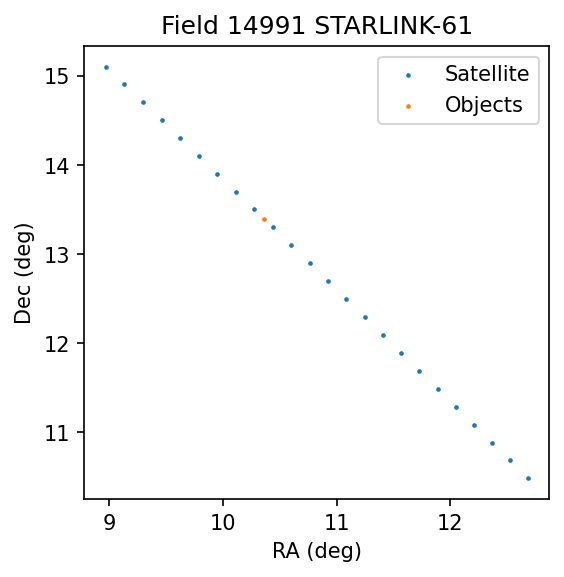

Number of objects affected: 1

Satellite times:
[59874.21695161904, 59874.21697476719, 59874.21699791533, 59874.21702106348, 59874.21704421163, 59874.21706735978, 59874.217090507926, 59874.21711365607, 59874.217136804225, 59874.21715995237, 59874.21718310052, 59874.217206248664, 59874.21722939682, 59874.217252544964, 59874.21727569311, 59874.21729884126, 59874.21732198941, 59874.21734513756, 59874.2173682857, 59874.21739143386, 59874.217414582, 59874.21743773015, 59874.217460878295, 59874.21748402645]

Right Ascension, SATELLITE:
[8.965615259574918, 9.130518307805062, 9.295110367446796, 9.45939945043142, 9.623390214047333, 9.787090598547195, 9.950498630684024, 10.113622215547707, 10.276465926868013, 10.439037601263635, 10.601335230843404, 10.763366618849886, 10.925139514353305, 11.086651897940214, 11.24791148662996, 11.408922736190675, 11.569693302622795, 11.730221134896453, 11.89051386006605, 12.050575863565427, 12.210414715873696, 12.370028335541633, 12.52942426614436, 12.68860682812

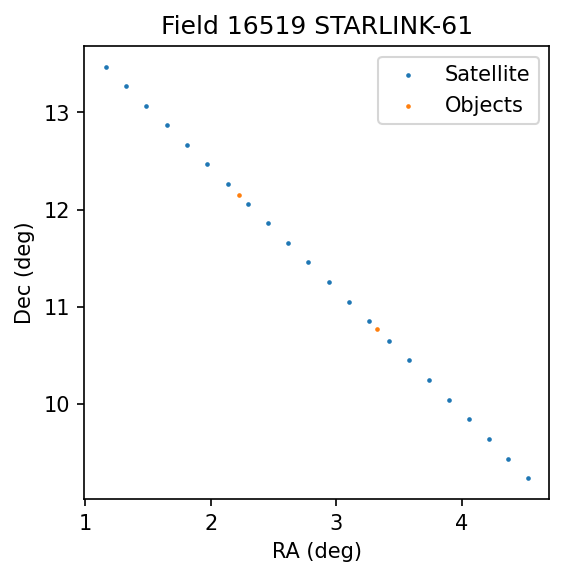

Number of objects affected: 2

Satellite times:
[59876.19557272031, 59876.195595868456, 59876.1956190166, 59876.195642164756, 59876.1956653129, 59876.19568846105, 59876.195711609194, 59876.19573475735, 59876.195757905494, 59876.19578105364, 59876.19580420179, 59876.19582734994, 59876.19585049809, 59876.19587364623, 59876.19589679438, 59876.19591994253, 59876.19594309068, 59876.195966238825, 59876.19598938697, 59876.196012535125, 59876.19603568327, 59876.19605883142]

Right Ascension, SATELLITE:
[1.1639430055217872, 1.3264749230197026, 1.4887367824559874, 1.6507363642717792, 1.812471652300701, 1.9739503886384568, 2.1351770320160313, 2.296159270265605, 2.4568950546912447, 2.6173920350324806, 2.777657823664242, 2.9376903517508026, 3.097497209024368, 3.2570827357755547, 3.4164544629676357, 3.5756102911375933, 3.7345577311378975, 3.8933010606531866, 4.051847732540523, 4.21019562236927, 4.368352164898454, 4.526324755590338]
Declination, SATELLITE
[13.471173889840006, 13.270318942365048, 13.0

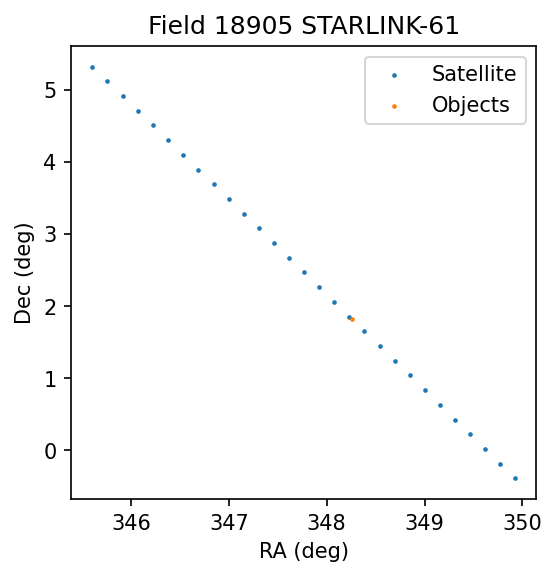

Number of objects affected: 1

Satellite times:
[59881.04460186402, 59881.04462501217, 59881.044648160314, 59881.04467130846, 59881.044694456614, 59881.04471760476, 59881.04474075291, 59881.04476390105, 59881.044787049206, 59881.04481019735, 59881.0448333455, 59881.044856493645, 59881.0448796418, 59881.044902789945, 59881.04492593809, 59881.044949086245, 59881.04497223439, 59881.04499538254, 59881.04501853068, 59881.04504167884, 59881.04506482698, 59881.04508797513, 59881.045111123276, 59881.04513427143, 59881.045157419576, 59881.04518056772, 59881.04520371587, 59881.04522686402, 59881.04525001217]

Right Ascension, SATELLITE:
[345.60639438662577, 345.76147698348296, 345.9164595970945, 346.0713462180181, 346.22614395183314, 346.38085055127266, 346.53547310396795, 346.69001868463073, 346.84448504018303, 346.9988792326741, 347.1532052193784, 347.30747004370994, 347.4616714452632, 347.61581645953595, 347.7699090256947, 347.92395616623384, 348.0779556124232, 348.23191438054994, 348.3858394

KeyboardInterrupt: 

In [54]:
# Time calculations output warnings --> ignore them
warnings.filterwarnings('ignore')

vecrubinxyz = 6371*radec2icrf(289.251, -30.24506) # Rubin xyz position in km

# first iterate through each satellite
for ch in chunks[:7]:
    sat_num = ch[0].strip()  # the label for each satellite --> STARLINK-xx
    s = ch[1]  # first line of TLE set
    t = ch[2]  # second line of TLE set
    sat = sg.Satrec.twoline2rv(s, t)  
    
    flag_2 = False

    # if True, satellite can't be propagated, so continue to next satellite
    if flag_2:
        continue
    
    # check each satellite against each FIELD
    for f in field_ids: #[100:1000]:
        ra_vals = []  # for satellite right ascensions
        dec_vals = []  # for satellite declinations
        sat_times = []  # for satellite times
        good_obj_times = [] # Observation times
        
        vectopsatlist = [] # for satellite topocentric vectors
        rangeobjects = [] # Distance to objects
        posrubin = []
        
        data = dfin[dfin['FieldID']==f]  # all objects in the field

        ra_f = data['AstRA(deg)']  # RA for all objects
        dec_f = data['AstDec(deg)']  # Dec for all objects
        range_f = data['AstRange(km)'] # Distance for all objects
                
        min_ra, max_ra = min(ra_f), max(ra_f) # Global minimum and maximums for objects in the field in question
        min_dec, max_dec = min(dec_f), max(dec_f)

        mjd_t = data['FieldMJD'].unique()[0]  # field time
        
        t = Time(mjd_t, format='mjd')  # convert to Time format
        t_change = TimeDelta(2.0, format='sec')
        
        flag = False
        
        count = 1
        
        # Start 30 seconds before field time
        t_before = t - TimeDelta(30.0, format='sec')
        
        # We're going to propagate every 2 seconds from 30 seconds before to 30 seconds after field time because exposure for the field is 30 seconds
        # Because of this, there will be 61 total iterations of propagations
        # If a satellite is within this time, it will leave a streak in the field image
        while count <= 61:
            jd_t = t_before + 2400000.5  # convert MJD to JD for sgp4 propagation calculation
            fr, whole = math.modf(float(str(jd_t)))  # fr = digits after decimal of MJD
    
            e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 12))  # r is [x,y,z] for propagated satellite
            x, y, z = r[0], r[1], r[2] # Possible issue due to Keplerian to non-Keplerian elements
            length = np.sqrt(x**2 + y**2 + z**2)
            norm_coords = np.array([x/length, y/length, z/length])  # normalizing onto unit sphere
            ra, dec = icrf2radec(norm_coords)  # convert to RA and Dec (Degrees)
            
            if ra != ra:  # if nan --> satellite can't be propagated to that time
                flag = True
                break  # don't bother looking at all the times 

            # if the object is in the field i.e. within 1 degree
            if (min_ra - 1.0 <= ra <= max_ra + 1.0) and (min_dec - 1.0 <= dec <= max_dec + 1.0): 
                ra_vals.append(ra)
                dec_vals.append(dec)
                sat_times.append(t_before.value) # times for satellite propagation
                
                # Calculate topocentric vector for satellite positions from Rubin
                ts = load.timescale()
                tsat = ts.tt_jd(t_before.value) # Appropriate time format for rotation matrix
                Rsat = ecliptic_frame.rotation_at(tsat) # Rotation matrix
                vectopsat = [x, y, z] - np.matmul(R, vecrubinxyz)
                vectopsatlist.append(vectopsat)
                
            
            t_before += t_change  # Propagate 2.0 seconds
            count += 1 
            
        if flag:
            print()
            print("Could not propagate " + sat_num)
            print()
            flag_2 = True
            break  # break out of for loop of the fields
                
        # Only satellite points that are within the field of objects
        if any(ra_vals) and any(dec_vals):
            good_obj_ra, good_obj_dec, good_obj_range = [], [], []
            
            obj_count = 0
            
            # for satellites
           
            min_ra_track, max_ra_track = ra_vals[0], ra_vals[-1]
            min_dec_track, max_dec_track = dec_vals[0], dec_vals[-1]
        
            
            min_long, max_long = np.deg2rad(min_ra_track), np.deg2rad(max_ra_track)  # Convert to radians 
        
            min_lat, max_lat = np.deg2rad(min_dec_track), np.deg2rad(max_dec_track)  
            

            for obj_r, obj_d, obj_range in zip(ra_f, dec_f, range_f): 
                obj_long = np.deg2rad(obj_r)
                obj_lat = np.deg2rad(obj_d)

                bound_d = 2.0 * np.pi/(180*3600)  # 2 arcseconds in radians

                # calculate cross track distance between satellite streak and objects
                dist = crosstrackdistance(min_lat, min_long, max_lat, max_long, obj_lat, obj_long) 
                
                # an object is considered obstructed if the satellite streak is within 2 arcseconds of it
                if (abs(dist) <= bound_d) and ((min_lat <= obj_lat <= max_lat) or (min_long <= obj_long <= max_long)):
                    good_obj_ra.append(obj_r)
                    good_obj_dec.append(obj_d)
                    good_obj_range.append(obj_range)
                    good_obj_times.append(t_before.value) # add observation time for objects
                    obj_count += 1 
                    
                    
            # only plot objects that are obstructed 
            if any(good_obj_ra):
                plt.figure(dpi=150,figsize=(4,4))
                plt.scatter(ra_vals, dec_vals, s=1.5, label='Satellite')
                plt.scatter(good_obj_ra, good_obj_dec, s=1.5, label='Objects')
                title = "Field " + str(f) + " " + sat_num
                plt.title(title)
                plt.xlabel('RA (deg)')
                plt.ylabel('Dec (deg)')
                plt.legend()
#                 plt.savefig(title)
                plt.show()

                print("Number of objects affected: " + str(obj_count))
                print()
                print("Satellite times:")
                print(str(sat_times))
                
                print()
                print("Right Ascension, SATELLITE:")
                print(ra_vals)
                print("Declination, SATELLITE")
                print(dec_vals)
                print()
                
                print()
                print("Right Ascension, OBJECTS:")
                print(good_obj_ra)
                print("Declination, OBJECTS")
                print(good_obj_dec)
                print()
                
                
                # Topocentric vector for relevant satellite positions 
                vectopsatlistdisp = np.array(vectopsatlist)
                print("Topocentric vector for satellite positions from Rubin (km):")
                print(vectopsatlistdisp)
                
                # RA and Dec of satellite positions from topocentric vector
                # vectop_RA, vectop_Dec = icrf2radec(vectopsatlistdisp)
                
                # print("Satellite RA from topocentric vector (Deg):")
                # print(vectop_RA)
                
                # print("Satellite Dec from topocentric vector (Deg):")
                # print(vectop_Dec)
                
                
                # Topocentric vector for relevant objects
                for obj in range(0, len(good_obj_ra)):
                    ts = load.timescale()
                    tobj = ts.tt_jd(good_obj_times[obj]) # Appropriate time format for rotation matrix
                    R = ecliptic_frame.rotation_at(tobj) # Rotation matrix
                    objpos_xyz = good_obj_range[obj]*radec2icrf(good_obj_ra[obj], good_obj_dec[obj])
                    vectopobj = objpos_xyz - np.matmul(R, vecrubinxyz)
            
                    print('Topocentric vector for object', obj, '(km):')
                    print(vectopobj)
                
                
                # nobjRangelist = np.array(good_obj_range)
                # nobjRA = np.array(good_obj_ra)
                # nobjDec = np.array(good_obj_dec)
                
                # vecobjnorm = radec2icrf(nobjRA, nobjDec)
                # veclistobj = np.multiply(nobjRangelist, vecobjnorm)
                
                # vectoplistobj = veclistobj - vecrubinxyz
                
                # print("Topocentric vector for object position (km):")
                # print(vectoplistobj)
                
                

In [21]:
vecrubinxyz = 6371*radec2icrf(289.251, -30.24506) # Rubin xyz position in km
print(vecrubinxyz)

[ 1814.63306332 -5196.01971357 -3209.06948845]


In [34]:
from skyfield.positionlib import Barycentric

x = 3141.0
y = 2718.0
z = 5820.0
barycentric = Barycentric([x, y, z])

In [29]:
hola = barycentric.position
print(hola)

[3141. 2718. 5820.] au


In [40]:
from skyfield.positionlib import Apparent

position = Apparent.from_radec(ra_hours=5.59, dec_degrees=5.45)
print(position)

<Apparent ICRS position and velocity>


In [42]:
from skyfield.positionlib import build_position

icrs_xyz_au = [-1.521, -1.800, -0.772]
position = build_position(icrs_xyz_au, t=t)


In [37]:
from skyfield.api import EarthSatellite
from skyfield.api import load, wgs84

ts = load.timescale()
t = ts.now()
print(t)

<Time tt=2459856.706174927>


In [38]:
from skyfield.framelib import ecliptic_frame

In [39]:
R = ecliptic_frame.rotation_at(t)
print(R)

[[ 9.99984939e-01 -5.03365341e-03 -2.18703703e-03]
 [ 5.48823985e-03  9.17488858e-01  3.97723615e-01]
 [ 4.57928142e-06 -3.97729628e-01  9.17502667e-01]]


In [45]:
tx = load.timescale(59853.98564424414)
print(tx)

In [47]:
ty = ts.tt_jd(59853.98564424414)
print(ty)

<Time tt=59853.98564424414>


In [49]:
R = ecliptic_frame.rotation_at(ty)
print(R)

[[-4.68689698e-03  9.11608539e-01  4.11032729e-01]
 [-9.99984386e-01 -5.52353012e-03  8.47799715e-04]
 [ 3.04321312e-03 -4.11022337e-01  9.11620194e-01]]
